<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Изучение-воронки-событий." data-toc-modified-id="Изучение-воронки-событий.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение воронки событий.</a></span></li><li><span><a href="#Изучение-результатов-эксперимента." data-toc-modified-id="Изучение-результатов-эксперимента.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение результатов эксперимента.</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Анализ поведения  пользователей мобильного приложения.

В нашем распоряжении данные стартапа, который продаёт продукты питания.

Цель исследования разобраться, как ведут себя пользователи мобильного приложения, а именно: 
- Изучить воронку продаж. 
- Узнать, как пользователи доходят до покупки. 
- Узнать сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

Исследование пройдет следующие этапы:
- Предобработка данных.
- Изучение и проверка данных.
- Изучение воронки событий.
- Изучение результатов эксперимента

Описание данных:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import display
from plotly import graph_objects as go
import math as mth
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv',  sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Заменим названия столбцов на более удобные.

In [4]:
data=data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 
                          'EventTimestamp':'timestamp','ExpId':'exp_id' })

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных не обнаружено. Добавим столбец даты и времени 'event_time' и столбец даты 'event_date'

In [6]:
data['event_time'] = pd.to_datetime(data['timestamp'], unit='s')
data['event_date'] = data['event_time'].dt.date
data.head()

,event_name,user_id,timestamp,exp_id,event_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим данные на наличие явных дубликатов.

In [7]:
if data.duplicated().sum()>0:
    print(f'Всего явных дубликатов: {data.duplicated().sum()}') 
    if data.duplicated().sum()/len(data) < 0.05:
        print(f'Доля дубликатов от всех данных: {(data.duplicated().sum())/len(data):.2%} - не превышает 5%, можем их удалить.')
    else:
        print(f'Доля дубликатов от всех данных: {(data.duplicated().sum())/len(data):.2%} - превышает 5%, необходимо изучить их.')
else:
    print('Явных дубликатов не обнаружено')             

Всего явных дубликатов: 413
Доля дубликатов от всех данных: 0.17% - не превышает 5%, можем их удалить.


In [8]:
data = data.drop_duplicates().reset_index()
data.duplicated().sum()

0

Для удобства сосздадим колонку 'group',  в которой контрольные группы обозначим А1 и А2, а экспериментальную В

In [9]:
def categorize_group(number):
    if number == 246:
        return 'A1'
    elif number == 247:
        return 'A2'
    elif number == 248:
        return 'B'      

In [10]:
data['group'] = data['exp_id'].apply(categorize_group)
data[['exp_id','group']]

,exp_id,group
0,246,A1
1,246,A1
2,248,B
3,248,B
4,248,B
...,...,...
243708,247,A2
243709,246,A1
243710,246,A1
243711,246,A1


Проверим есть ли пользователи, которые попали в разные группы теста одновременно.

In [11]:
dupl_users = data.groupby('user_id').agg({'group':'nunique'}).query('group > 1').reset_index()
print(len(dupl_users))

0


Никто из пользователей не попал в разные группы теста одновременно.

В ходе предобработки данных мы:
- изменили названия столбцов на более удобные;
- добавили столбцы даты и времени и отдельно даты;
- очистили данные от явных дубликатов;
- добавили столбец с обозначением групп;
- проверили группы на наличие дублирующихся пользователей.

## Изучение и проверка данных

In [12]:
print(f'Всего в логе { data.event_name.count() } событий.')
data.event_name.value_counts()

Всего в логе 243713 событий.


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [13]:
print(f'Всего в логе { data.user_id.nunique() } пользователь.')

Всего в логе 7551 пользователь.


In [14]:
print(f'В среднем на пользователя приходится {round(data.event_name.count()/data.user_id.nunique())} события.')

В среднем на пользователя приходится 32 события.


In [15]:
print('Минимальная дата:', data['event_time'].min().date())
print('Максимальная дата:', data['event_time'].max().date())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


In [16]:
data['event_time'].max().date()-data['event_time'].min().date()

datetime.timedelta(days=13)

Мы распологаем данными за период в 13 дней с 25-07-2019 по 07-08-2019.

In [17]:
data.groupby('event_date')['event_name'].count()

event_date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

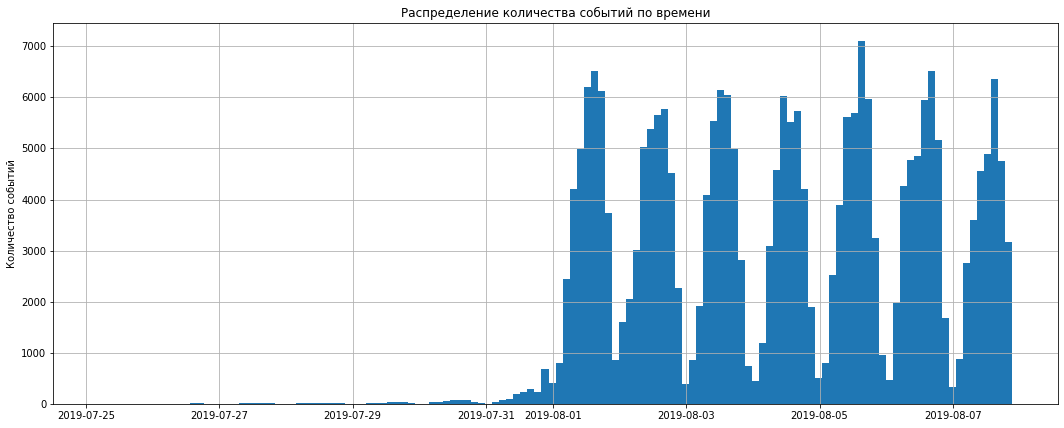

In [18]:
plt.figure(figsize=(18,7))
data['event_time'].hist(bins=130)
plt.title('Распределение количества событий по времени')
plt.ylabel('Количество событий');

На гистограме видим, что данных до 01-08-2019 аномально мало в сравнении с периодом после 01-08-2019. Можем сделать вывод, что это ошибочно подгруженные события из прошлого, отфильтруем их.

In [19]:
data_filtred=data.query('event_time >= "2019-08-01"')

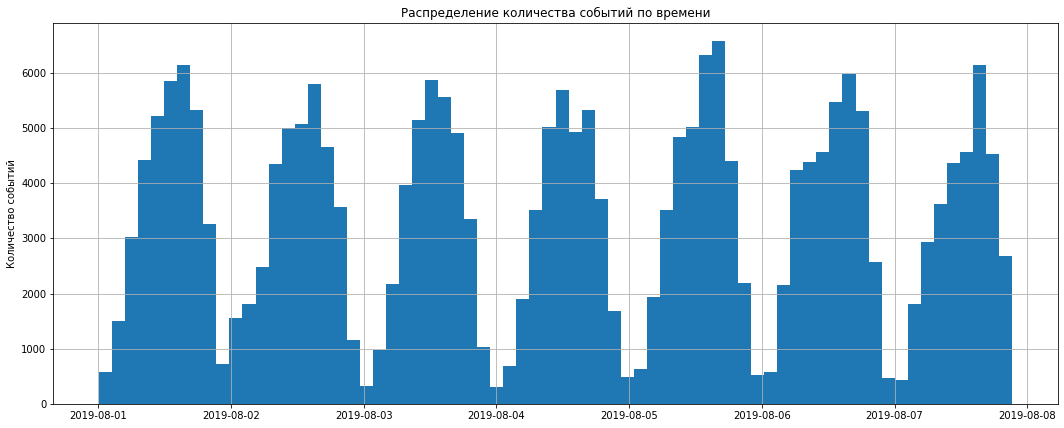

In [20]:
plt.figure(figsize=(18,7))
data_filtred['event_time'].hist(bins=70)
plt.title('Распределение количества событий по времени')
plt.ylabel('Количество событий');

Теперь гистограма выглядит более правдоподобно, каждый день видим распределение событий близкое к нормальному. Мы распологаем данными за период в 7 дней с 01.08.2019 по 07.08.2019.

In [21]:
print(f'После фильтрации данных мы потеряли {len(data)-len(data_filtred)} событий, это {1-len(data_filtred)/len(data):.2%} от всех данных.')

После фильтрации данных мы потеряли 2826 событий, это 1.16% от всех данных.


In [22]:
print('Полсе фильтрации данных мы потеряли', data['user_id'].nunique()-data_filtred['user_id'].nunique(), 'пользователей')

Полсе фильтрации данных мы потеряли 17 пользователей


In [23]:
data.groupby('group')['user_id'].nunique()

group
A1    2489
A2    2520
B     2542
Name: user_id, dtype: int64

In [24]:
data_filtred.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

В данных присутствуют пользователи всех трех экспериментальных груп, распределение пользователей по групам существнно не  изменилось. 

В процессе изучения и проверки данных определили:
- всего в логе 243713 событий;
- всего в логе 7551 пользователь;
- в среднем на пользователя приходится 32 события.

Изначально мы распологали данными за период в 13 дней с 25-07-2019 по 07-08-2019, но отфильтровав старые и неполные данные мы получили актуальный период в 7 дней с 01.08.2019 по 07.08.2019, во время фильтрации мы потеряли это 1.16% от всех данных.

## Изучение воронки событий.

Посмотрим какие события и как часто встречаются в логах.

In [25]:
data_filtred.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Видим 5 событий:
- MainScreenAppear - просмотр главной страницы
- OffersScreenAppear - просмотр страницы предложений
- CartScreenAppear - просмотр корзины
- PaymentScreenSuccessful - переход на страницу успешной оплаты
- Tutorial - просмотр обучающей информации для новых пользователей

Посчитаем сколько пользователей совершали каждое из этих событий.

In [26]:
events = (data_filtred.groupby('event_name').agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})
          .sort_values(by='users', ascending=False)).reset_index()
events

,event_name,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


 Посчитаем долю пользователей, которые хоть раз совершали событие.

In [27]:
events['percent'] = round((events['users'] / data_filtred['user_id'].nunique() * 100))
events

,event_name,users,percent
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


Предположительная последовательность движения пользователя по приложению:
1. MainScreenAppear - просмотр главной страницы;
2. OffersScreenAppear - просмотр страницы предложений;
3. CartScreenAppear - просмотр корзины;
4. PaymentScreenSuccessful - переход на страницу успешной оплаты.

Этап Tutorial - просмотр обучающей информации для новых пользователей является не обязательным.
Попробуем построить воронку событий.

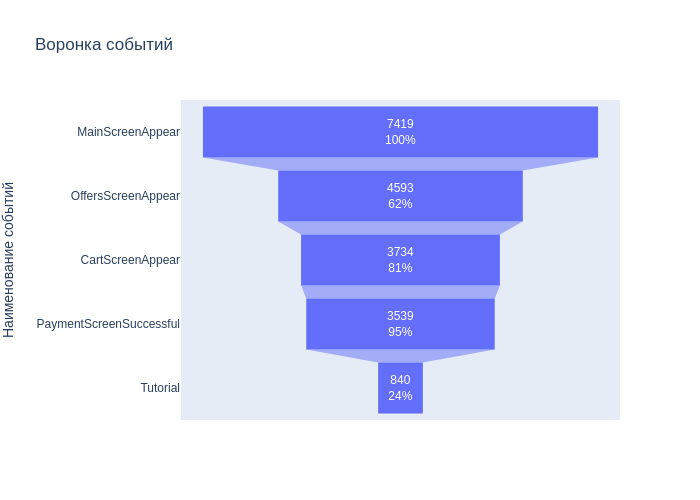

In [28]:
fig = go.Figure(go.Funnel(y= events['event_name'], x=events['users'], textposition="inside",
                         textinfo = 'value+percent previous'))
fig.update_layout(title='Воронка событий', 
                 yaxis_title='Наименование событий')
fig.show()

Если навести курсор на каждый шаг воронки, увидим, какая доля пользователей на этом шаге составляет от:

- числа пользователей на первом шаге (of initial),
- числа пользователей на предыдущем шаге (of previous),
- суммы пользователей на всех шагах (of total).

Этап Tutorial прошли всего 4,2 % от всех пользователей, можем смело удалить его из воронки как не обязательный.

In [29]:
events = events.query('event_name != "Tutorial"')

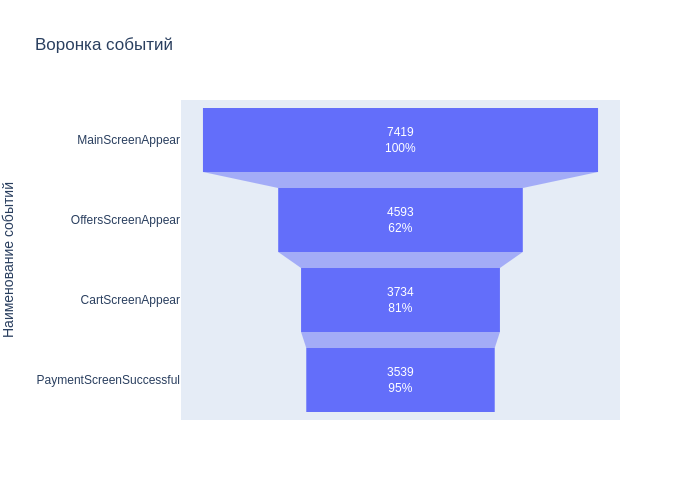

In [30]:
fig = go.Figure(go.Funnel(y= events['event_name'], x=events['users'], textposition="inside",
                         textinfo = 'value+percent previous'))
fig.update_layout(title='Воронка событий', 
                 yaxis_title='Наименование событий')
fig.show()

Больше всего пользователей, почти 40%, мы теряем при переходе от просмотра главной страницы к просмотру страницы с предложениями.
От просмотра главной страницы до успешной оплаты доходят около 48% пользователей.
На этапе перехода от корзины до успешной оплаты мы теряем около 5% пользователей.

На данном этапе исследования мы определили, что воронка событий выглядит таким образом :
1. MainScreenAppear - просмотр главной страницы;
2. OffersScreenAppear - просмотр страницы предложений; 
3. CartScreenAppear - просмотр корзины; 
4. PaymentScreenSuccessful - переход на страницу успешной оплаты. 

Больше всего пользователей, почти 40%, мы теряем при переходе от просмотра главной страницы к просмотру страницы с предложениями.
От просмотра главной страницы до успешной оплаты доходят около 48% пользователей. 

## Изучение результатов эксперимента.

Посмотрим сколько пользователей в каждой экспериментальной группе.

In [31]:
group = data_filtred.groupby('group')['user_id'].nunique()
group

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

 Проверим, есть ли разница между выборками А1 и А2 при помощи z-критерия. Сформулируем гипотезы:
 - Н0: Между долями нет статистически значимой разницы;
 - Н1: Между долями есть статистически значимая разница.

Соберем данные о каждом этапе воронки для каждой группы теста в таблицу

In [32]:
values = (data_filtred.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique')
.query('event_name!="Tutorial"').reset_index())
values['total'] = values['A1']+ values['A2']+ values['B']
values = values.sort_values(by='total', ascending = False)
values

group,event_name,A1,A2,B,total
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
0,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539


Обозначим функцию для подсчета z-критерия.

In [33]:
def z_critery(values, trials, col1, col2):
    for i in range(0, 4):
        # критический уровень статистической значимости  
        alpha = 0.05
        
        successes = np.array([values.loc[i, col1], values.loc[i, col2]])  
        
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]    
        
        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]   
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])   
        
        # разница пропорций в датасетах
        difference = p1 - p2    
        
        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))   
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)   
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2  
         
        print('{} p-значение: {}'.format(values['event_name'][i], p_value))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---------------------------------------------------------------------------------')            

In [34]:
trials = np.array([group[0], group[1]])
z_critery(values, trials, 'A1','A2') 

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


Проверка при помощи z-критерия показала, что статистически значимой разницы между выборками А1 и А2 нет.

Самое популярное событие это MainScreenAppear - просмотр главной страницы.

In [35]:
msa = (data_filtred.query('event_name == "MainScreenAppear"')
       .groupby('group').agg({"user_id":'nunique'}).rename(columns={'user_id':'users'}))
msa['percent'] = round(msa['users']*100/group,2)
msa

,users,percent
group,,
A1,2450,98.63
A2,2476,98.53
B,2493,98.27


Почти все пользователи каждой из групп просмотрели главную страницу. Остаеться небольшой процент пользователей которые миновали MainScreenAppear скорее всего они попали в приложение по ссылке от друга или из рекламных материалов.

 Проверим, есть ли разница между группами А1 и В при помощи z-критерия. Сформулируем гипотезы:
 - Н0: Между долями нет статистически значимой разницы;
 - Н1: Между долями есть статистически значимая разница.

In [36]:
trials = np.array([group[0], group[2]])
z_critery(values, trials, 'A1','B') 

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


Проверка при помощи z-критерия показала, что статистически значимой разницы между выборками А1 и B нет. Проверим группы А2 и В.
Сформулируем гипотезы:
 - Н0: Между долями нет статистически значимой разницы;
 - Н1: Между долями есть статистически значимая разница.

In [37]:
trials = np.array([group[1], group[2]])
z_critery(values, trials, 'A2','B') 

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


Проверка при помощи z-критерия показала, что статистически значимой разницы между выборками А2 и B нет. Проверим результаты с объединенной контрольной группой А1+А2 и В.
Сформулируем гипотезы:
 - Н0: Между долями нет статистически значимой разницы;
 - Н1: Между долями есть статистически значимая разница.
 
 Дополним таблицы values и group.

In [38]:
values['A1A2'] = values['A1']+values['A2']
values

group,event_name,A1,A2,B,total,A1A2
1,MainScreenAppear,2450,2476,2493,7419,4926
2,OffersScreenAppear,1542,1520,1531,4593,3062
0,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358


In [39]:
group['A1A2'] = group[0]+group[1]
group

group
A1      2484
A2      2513
B       2537
A1A2    4997
Name: user_id, dtype: int64

In [40]:
trials = np.array([group[3], group[2]])
z_critery(values, trials, 'A1A2','B') 

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


Проверка при помощи z-критерия показала, что статистически значимой разницы между группами А1+А2 и В нет.

Мы провели проверки на наличие статистически значимой разницы контрольных групп А1 и А2 между собой, контрольной группы А1 и экспериментальной B, контрольной А2 и экспериментальной В, суммарной контрольной группы А1+А2  и экспериментальной В все проверки показали, что нет оснований считать группы разными - то есть изменение шрифтов никак не повлияло на поведение пользователей приложения.

Но так как мы имеем дело с множественным тестом, с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод Шидака. Мы провели 3 теста А1-В, А2-В и (А1+А2)-В по 4-м этапам воронки, итого мы сделали 12 проверок.

In [41]:
# текущий уровень значимости
ɑlpha = 0.05
# количество сравнений
m = 12
# новый уровень значимости
alpha_m =  1 - (1 - ɑlpha)**(1/m)
alpha_m

0.004265318777560645

Добавим метод Шидака в нашу функцию: 

In [42]:
def z_critery_shidak(values, trials, col1, col2):
    for i in range(0, 4):
        # критический уровень статистической значимости  
        alpha = 0.05
        # количество сравнений
        m = 12
        # новый уровень значимости
        alpha_m =  1 - (1 - ɑlpha)**(1/m)
        
        successes = np.array([values.loc[i, col1], values.loc[i, col2]])  
        
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]    
        
        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]   
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])   
        
        # разница пропорций в датасетах
        difference = p1 - p2    
        
        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))   
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)   
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2  
         
        print('{} p-значение: {}'.format(values['event_name'][i], p_value))
        if p_value < alpha_m:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---------------------------------------------------------------------------------')            

Теперь повторим А-В тест с применением метода Шидака. Проверим, есть ли разница между группами А1 и В. Сформулируем гипотезы:
 - Н0: Между долями нет статистически значимой разницы;
 - Н1: Между долями есть статистически значимая разница.

In [43]:
trials = np.array([group[0], group[2]])
z_critery_shidak(values, trials, 'A1','B') 

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


In [44]:
trials = np.array([group[1], group[2]])
z_critery_shidak(values, trials, 'A2','B') 

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


In [45]:
trials = np.array([group[3], group[2]])
z_critery(values, trials, 'A1A2','B') 

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


Мы провели проверки на наличие статистически значимой разницы контрольных групп А1 и А2 между собой, контрольной группы А1 и экспериментальной B, контрольной А2 и экспериментальной В, суммарной контрольной группы А1+А2  и экспериментальной В. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез мы применили метод Шидака. Все проверки показали, что нет оснований считать группы разными - то есть изменение шрифтов никак не повлияло на поведение пользователей приложения.

## Выводы

В процессе исследования мы:
- провели предобработку и проверку данных;
- изучили воронку продаж;
- узнали, как пользователи доходят до покупки;
- узнали сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах;
- проанализировали результаты A/A/B-эксперимента. 

В процессе изучения и проверки данных определили:
- всего в логе 243713 событий;
- всего в логе 7551 пользователь;
- в среднем на пользователя приходится 32 события.
- мы распологаем данными за период в 7 дней с 01.08.2019 по 07.08.2019.

Воронка событий выглядит таким образом : 
1.  MainScreenAppear - просмотр главной страницы 
2. OffersScreenAppear - просмотр страницы предложений 
3. CartScreenAppear - просмотр корзины 
4. PaymentScreenSuccessful - переход на страницу успешной оплаты. 

Больше всего пользователей, почти 40%, мы теряем при переходе от просмотра главной страницы к просмотру страницы с предложениями. От просмотра главной страницы до успешной оплаты доходят около 48% пользователей.

Во время А/А/B-теста пользователей разбили на 3 группы: 2 контрольные которые пользовались приложением со старыми шрифтами (А1 и А2) и одну экспериментальную —  с измененными шрифтами (В). Мы провели проверки на наличие статистически значимой разницы контрольных групп А1 и А2 между собой, контрольной группы А1 и экспериментальной B, контрольной А2 и экспериментальной В, суммарной контрольной группы А1+А2  и экспериментальной В. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез мы применили метод Шидака. Все проверки показали, что нет оснований считать группы разными - то есть **изменение шрифтов никак не повлияло на поведение пользователей приложения**.